# Recommender Systems

# Exercises: Building an Item-Item Recommender

If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation. 

In this tutorial, we will generate item-item recommendations using collaborative filtering. Let's get started! 

## Exercise 1: Load the Data

We're working with data in `data/ml-latest-small/` directory which contains the following files:
- `ratings.csv`
- `movies.csv`

The `ratings.csv` file contains ratings from users. Each row contains a user, a movie, a rating, and a timestamp.

The `movies.csv` file contains movie titles and their corresponding movieId's and genres.

###  <span style="color:green">1. Let's load in our data using pandas and take a look at the first few rows of each dataframe.</span>

In [1]:
import pandas as pd

ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [2]:
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Exercise 2: Exploratory Data Analysis

### <span style="color:green">2.1: How many ratings are in our dataset?</span>
### <span style="color:green">2.2: How many unique movies are in our dataset?</span>
### <span style="color:green">2.3: How many users are in our dataset?</span>
### <span style="color:green">2.4: What is the average number of ratings per user?</span>
### <span style="color:green">2.5: What is the average number of ratings per movie?</span>


In [3]:
n_ratings = len(ratings)
n_movies = ratings["movieId"].nunique()
n_users = ratings["userId"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### <span style="color:green">2.6: Plot the distribution of ratings and the number of ratings per movie.</span>

Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `userId`'s and counts the number of ratings for each userId. 

In [4]:
user_freq = ratings[["userId", "movieId"]].groupby("userId").count()
user_freq

,movieId
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


Text(0.5, 1.0, 'Kde')

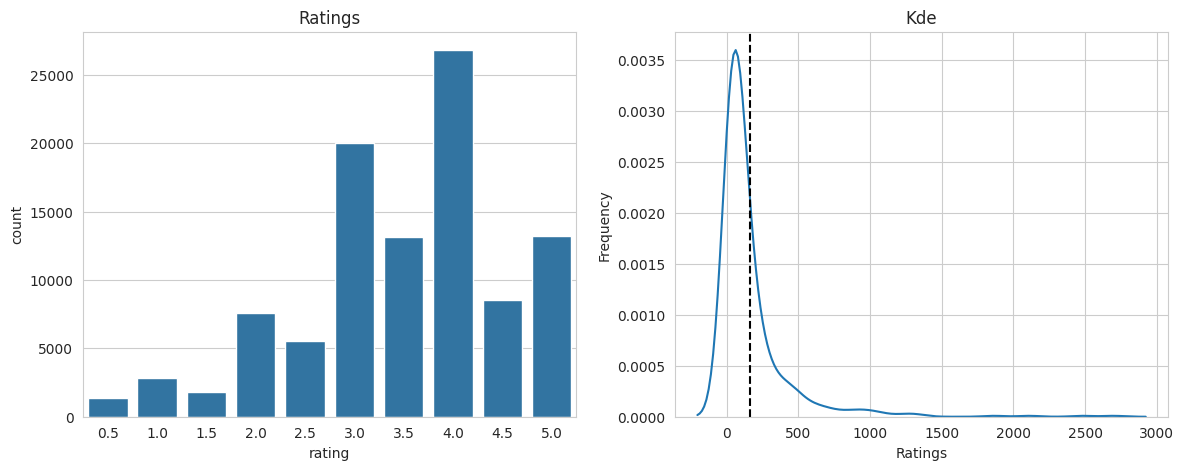

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x="rating", data=ratings)
plt.title("Ratings")

user_freq = user_freq.reset_index()
user_freq.columns = ["userId", "n_ratings"]

plt.subplot(1, 2, 2)
ax = sns.kdeplot(x=user_freq['n_ratings'])
plt.axvline(user_freq['n_ratings'].mean(), linestyle='--', color='black')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Kde")

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. 

### <span style="color:green">2.7: Which movie has the lowest and highest average rating?</span>

In [6]:
mean_rating = ratings.groupby("movieId")[["rating"]].mean()

lowest_rated = mean_rating["rating"].idxmin()
highest_rated = mean_rating["rating"].idxmax()

movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


One of the lowest rated movies is `Gypsy (1962)`.

In [7]:
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


`Lamerica (1994)` may be the "highest" rated movie, but how many ratings does it have?

### <span style="color:green">2.8: How many ratings does the highest rated movie have?</span>

In [8]:
ratings[ratings['movieId'] == 53]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica has only 2 ratings. A better approach for evaluating movie popularity is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given movie.

### <span style="color:green">2.9: Calculate the Bayesian average for each movie.</span>

In [9]:
movie_stats = ratings.groupby("movieId")[['rating']].agg(["count", "mean"]).reset_index()
movie_stats.columns = ["movieId", "count", "mean"]
movie_stats

,movieId,count,mean
0,1,215,3.920930
1,2,110,3.431818
2,3,52,3.259615
3,4,7,2.357143
4,5,49,3.071429
...,...,...,...
9719,193581,1,4.000000
9720,193583,1,3.500000
9721,193585,1,3.500000
9722,193587,1,3.500000


In [10]:
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

def bayesian_avg(ratings):
    return (C*m+ratings.sum()) / C + ratings.count()

bayesian_stats = ratings.groupby("movieId")[['rating']].agg(bayesian_avg).reset_index()
bayesian_stats.columns = ["movieId", "bayesian_avg"]
movie_stats = movie_stats.merge(bayesian_stats, on="movieId")
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,299.556153
1,2,110,3.431818,149.666213
2,3,52,3.259615,71.607980
3,4,7,2.357143,11.853606
4,5,49,3.071429,66.775737
...,...,...,...,...
9719,193581,1,4.000000,4.648184
9720,193583,1,3.500000,4.599967
9721,193585,1,3.500000,4.599967
9722,193587,1,3.500000,4.599967


In [11]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']], on="movieId")
movie_stats

,movieId,count,mean,bayesian_avg,title
0,1,215,3.920930,299.556153,Toy Story (1995)
1,2,110,3.431818,149.666213,Jumanji (1995)
2,3,52,3.259615,71.607980,Grumpier Old Men (1995)
3,4,7,2.357143,11.853606,Waiting to Exhale (1995)
4,5,49,3.071429,66.775737,Father of the Bride Part II (1995)
...,...,...,...,...,...
9719,193581,1,4.000000,4.648184,Black Butler: Book of the Atlantic (2017)
9720,193583,1,3.500000,4.599967,No Game No Life: Zero (2017)
9721,193585,1,3.500000,4.599967,Flint (2017)
9722,193587,1,3.500000,4.599967,Bungo Stray Dogs: Dead Apple (2018)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `Fight Club` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

### <span style="color:green">2.10: Now which movies are the worst rated, according to the Bayesian average?</span>

In [13]:
movie_stats.sort_values('bayesian_avg', ascending=True, inplace=True)
movie_stats

,movieId,count,mean,bayesian_avg,title
6514,54274,1,0.500000,4.310665,I Know Who Killed Me (2007)
7280,76030,1,0.500000,4.310665,Case 39 (2009)
5763,31422,1,0.500000,4.310665,Are We There Yet? (2005)
5764,31424,1,0.500000,4.310665,Alone in the Dark (2005)
8297,107013,1,0.500000,4.310665,"Christmas Carol, A (1977)"
...,...,...,...,...,...
1938,2571,278,4.192446,393.656058,"Matrix, The (1999)"
510,593,279,4.161290,394.222106,"Silence of the Lambs, The (1991)"
257,296,307,4.197068,434.517417,Pulp Fiction (1994)
277,318,317,4.429022,455.655522,"Shawshank Redemption, The (1994)"


In [14]:
movie_stats.sort_values('bayesian_avg', ascending=False, inplace=True)
movie_stats

,movieId,count,mean,bayesian_avg,title
314,356,329,4.164134,464.376773,Forrest Gump (1994)
277,318,317,4.429022,455.655522,"Shawshank Redemption, The (1994)"
257,296,307,4.197068,434.517417,Pulp Fiction (1994)
510,593,279,4.161290,394.222106,"Silence of the Lambs, The (1991)"
1938,2571,278,4.192446,393.656058,"Matrix, The (1999)"
...,...,...,...,...,...
3230,4371,1,0.500000,4.310665,Baby Boy (2001)
4994,7742,1,0.500000,4.310665,Baxter (1989)
8966,138798,1,0.500000,4.310665,Joe Dirt 2: Beautiful Loser (2015)
9572,175475,1,0.500000,4.310665,The Emoji Movie (2017)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all!

## Exercise 3: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 


<img src="img/user-movie-matrix.png" width="500px" align="left">

### <span style="color:green">3.1: Create the user-item matrix.</span>

The `user_item_matrix()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **_user_item_matrix** matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

This matrix can be created using the following constructor:
```txt
csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
    where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k].
```

In [29]:
from scipy.sparse import csr_matrix
import numpy as np

def user_item_matrix(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df["userId"].nunique()
    M = df["movieId"].nunique()
    
    user_map = dict(zip(np.unique(df["userId"]), range(N)))
    movie_map = dict(zip(np.unique(df["movieId"]), range(M)))
    
    user_inv_map = dict(zip(range(N), np.unique(df["userId"])))
    movie_inv_map = dict(zip(range(M), np.unique(df["movieId"])))
    
    user_index = [user_map[_i] for _i in df["userId"]]
    movie_index = [movie_map[_i] for _i in df["movieId"]]
    
    _user_item_matrix = csr_matrix((df["rating"], (movie_index, user_index)), (M, N))
    return _user_item_matrix, user_map, movie_map, user_inv_map, movie_inv_map

In [30]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = user_item_matrix(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{\# non-zero elements}}{\text{total elements}}$$

In [31]:
sparsity = X.count_nonzero() / (X.shape[0] * X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

### Writing your matrix to a file

We can save our user-item matrix to a file using the `scipy.sparse.save_npz` function. This function saves the matrix in a `.npz` format which can be loaded later using the `scipy.sparse.load_npz` function.

In [32]:
from scipy.sparse import save_npz

save_npz('data/user_item_matrix.npz', X)

<img src="img/knn.png" width="20%" align="right"/>

## Exercise 4: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where `M` represents the number of movies in our `user_item_matrix`. 

## <span style="color:green">4.1: Implement the `find_similar_movies()` function.</span>

The `find_similar_movies()` function takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest.

The function has the following parameters:
- `movie_id`: id of the movie of interest
- `X`: user-item utility matrix
- `k`: number of similar movies to retrieve
- `metric`: distance metric for kNN calculations
- `show_distance`: whether to show the distance between the movies

The function returns a list of k similar movie ID's.

**Note: You can use the `NearestNeighbors` class from the `sklearn.neighbors` module to find the k-nearest neighbours.**

In [75]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(X)
    neighbors = knn.kneighbors(movie_vec, n_neighbors=k, return_distance=show_distance)
    neighbour_ids = []
    for i in range(0, k):
        n = neighbors[1][0][i]
        neighbour_ids.append(movie_inv_mapper[n])
    return neighbour_ids

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [76]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, k=5, show_distance=True)

movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in range(len(similar_movies)):
    movie_title = movie_titles[similar_movies[i]]
    print(movie_title)
    

Because you watched Toy Story (1995)
Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.  

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [20]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)
